# Goodreads Books Review Rating Prediction
(https://www.kaggle.com/competitions/goodreads-books-reviews-290312/)
---

> Reviews are a good way to judge the quality of any product, whether it's books, clothes, technology, or anything else. When you want to buy something online these days, the first thing that comes to mind is the reviews from past buyers and the overall rating the product has received.

> Reader feedback, whether positive or negative, five stars or one star, will encourage the product owner to make improvements.

> Reader connection and engagement will be encouraged by book reviews, whether they be left on Amazon, Goodreads, or social media. Readers must determine whether or not other readers are enjoying the book.




Here are the columns of the dataset


*   book_id - Id of Book

*   review_id - Id of review

*   rating - rating from 0 to 5

*   review_text - review text

*   date_added - date added

*   date_updated - date updated

*   read_at - read at


*  started_at - started at


*   n_votes - no. of votes


*   n_comments - no. of comments



**Model (BERT and Fine Tuning)**

- BERT is designed as an adaptable model that requires fine-tuning to handle specific tasks, such as sentiment analysis.

- Fine-tuning involves adapting this pre-trained model to a related task, known as a downstream task, without needing any changes to the models architecture.

- Google originally pre-trained BERT at a cost of about $7,000 over five days using 16 TPUs. This pre-training allows users to achieve better performance with less time and expense by leveraging the pre-trained model.

- We utilize DistilBERT, a streamlined and quicker variant of BERT, through the Hugging Face Transformers package. This Python library provides access to various pre-trained NLP models, enabling efficient and effective model deployment.

# **Author : Firda Puspita Devi**

## Install Huggingface Transformers

In [9]:
!pip install transformers

## Configuration

First, we will need to enable GPUs for the notebook:

Navigate to Edit→Notebook Settings
select GPU from the Hardware Accelerator drop-down

In [10]:
# import tensorflow as tf

# num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
# print("Num GPUs Available: ", num_gpus_available)
# assert num_gpus_available > 0

## Install Huggingface Transformers

In [11]:
!pip install transformers

In [12]:
!pip show tensorflow transformers

Name: tensorflow
Version: 2.8.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, protobuf, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, tf-estimator-nightly, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras
---
Name: transformers
Version: 4.18.0
Summary: State-of-the-art Natural Language Processing for TensorFlow 2.0 and PyTorch
Home-page: https://github.com/huggingface/transformers
Author: Thomas Wolf, Lysandre Debut, Victor Sanh, Julien Chaumond, Sam Shleifer, Patrick von Platen, Sylvain Gugger, Suraj Patil, Stas Bekman, Google AI Language Team Authors, Open AI team Authors, Facebook AI Authors, Carnegie Mellon University

In [14]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


## Dependencies

In [15]:
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification
from io import StringIO
from scipy import stats
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch, Objective


import tensorflow as tf
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load data from Kaggle


In [17]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1/kaggle.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [18]:
!kaggle competitions download -c goodreads-books-reviews-290312

 98% 625M/635M [00:05<00:00, 145MB/s]
100% 635M/635M [00:05<00:00, 121MB/s]


In [19]:
!unzip goodreads-books-reviews-290312.zip -d "/content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1"

Archive:  goodreads-books-reviews-290312.zip
replace /content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1/goodreads_sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1/goodreads_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1/goodreads_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


## Limit to get only 20k records of train data or 2% of each rating

In [20]:
data = pd.read_csv("/content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1/goodreads_train.csv")

total_records_needed = 20000

# Calculate the total number of records for each rating
rating_counts = data['rating'].value_counts()

# Calculate 1% of each rank's total number
rating_sample_sizes = (rating_counts * 0.02).astype(int)

# Here we scale down the sample sizes proportionally if the sum exceeds 10.000
if rating_sample_sizes.sum() > total_records_needed:
    scaling_factor = total_records_needed / rating_sample_sizes.sum()
    rating_sample_sizes = (rating_sample_sizes * scaling_factor).astype(int)


# Sampling data according to calculated sample sizes
samples = []
for rating, size in rating_sample_sizes.items():
    rating_samples = data[data['rating'] == rating].sample(n=size, random_state=1)
    samples.append(rating_samples)

# Concatenate all samples into a new DataFrame
data = pd.concat(samples)


print(rating_sample_sizes)

rating
4    6273
5    5300
3    3779
2    1452
0     619
1     574
Name: count, dtype: int64


In [21]:
# Validate the number of records and proportions
print("Total records sampled:", data.shape[0])
print(data['rating'].value_counts(normalize=True))  # Check the percentage distribution

Total records sampled: 17997
rating
4    0.348558
5    0.294494
3    0.209979
2    0.080680
0    0.034395
1    0.031894
Name: proportion, dtype: float64


In [22]:
data.head(10)

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
329091,57fa81f98fad08b7cbb1ed6bded963fa,13412515,dcdfc4fca4e42ad34a1396d6c85d9e69,4,I figured this was a trend of all the mend tha...,Fri Jan 13 02:11:22 -0800 2017,Fri Jan 13 02:18:00 -0800 2017,Fri Jan 13 00:00:00 -0800 2017,NaN,1,0
728118,ffa5094acb2bca8fc8655538e60c400e,21469090,2f7f06bbce07261f1c639a0473e9ca06,4,So much fun! Not sure I'm going to like as muc...,Sun Dec 21 22:49:44 -0800 2014,Mon May 04 21:41:01 -0700 2015,Fri Dec 05 00:00:00 -0800 2014,NaN,2,0
631878,b1f531936f47624ab657289b22317473,17661699,f63d6177217080f67b2ffa005e662917,4,Rainy Dey heads off to college as a freshman. ...,Mon Jan 06 06:31:21 -0800 2014,Sat Jun 24 11:00:04 -0700 2017,Thu Jan 16 00:00:00 -0800 2014,Wed Jan 15 00:00:00 -0800 2014,0,0
291346,b4e0d01dc49db4b9d1a8d0466f4a3072,11454587,6e87495c835caafdd6e1ee3d5fceb7d1,4,So you know what I was just thinking today? Ho...,Sun Jul 28 07:36:13 -0700 2013,Thu Aug 08 19:45:18 -0700 2013,Thu Aug 08 00:00:00 -0700 2013,Tue Aug 06 00:00:00 -0700 2013,0,0
836206,d644a5428ea2450651f68935d66425db,6148028,396d2fa0a1dd1802440462ecc4665fd1,4,A good continuation from the previous book. Br...,Tue Jan 14 10:18:43 -0800 2014,Sun Aug 10 17:51:09 -0700 2014,Thu Aug 07 00:00:00 -0700 2014,Tue Aug 05 00:00:00 -0700 2014,0,0
246839,bd9347e112ea93e4efb889e24f825626,42899,e484a03028db34f7bcd4d26e771f839c,4,"You know, I resisted the whole vampire/werewol...",Sun Jul 01 20:50:17 -0700 2007,Sun Jul 01 21:03:20 -0700 2007,NaN,NaN,0,0
127797,ea1d434bf3285477ecdcdb4e09174403,183660,49c77fbaa4558f41fbf022cd37b2eea4,4,"An interesting retelling of Snow White. Sure, ...",Wed Dec 02 15:50:15 -0800 2009,Tue Dec 15 19:09:59 -0800 2009,Tue Dec 15 00:00:00 -0800 2009,NaN,0,1
234979,4c445b4b34fc8f4ada2ddcd819a05b58,6777616,43ce000161e07014c1d805471cbf73a1,4,"Like so many of the mysteries I love, this one...",Sat Jul 09 18:51:04 -0700 2016,Fri Aug 12 06:14:57 -0700 2016,Thu Aug 11 00:00:00 -0700 2016,Sat Jul 09 00:00:00 -0700 2016,1,0
332248,c4ccb23db8dee77cd923de30d836afae,10558533,106dca9e8f2ad428ce5701293fafb0a0,4,The German edition cover is so much better. An...,Mon Apr 01 08:07:01 -0700 2013,Fri Jun 07 12:19:32 -0700 2013,Fri Jun 07 12:19:32 -0700 2013,Mon Jun 03 00:00:00 -0700 2013,0,2
725231,59a514bb7433cc389b2657b6c0c2d3bb,13564634,cb467ef010f5e8591018d081934b9d70,4,When I originally saw this book I was not inte...,Thu May 10 07:23:06 -0700 2012,Sun Jun 24 07:58:52 -0700 2012,Mon Jun 04 00:00:00 -0700 2012,Thu May 31 00:00:00 -0700 2012,1,0


In [23]:
data.tail(10)

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
794535,d8a08df021db1fc767449668280360d7,18490661,efa01c81eeb72c78d7d92295b2e835bb,1,I'm afraid I don't have anything good to say a...,Mon Feb 15 16:34:29 -0800 2016,Tue Mar 29 14:38:19 -0700 2016,Tue Feb 16 00:00:00 -0800 2016,Mon Feb 15 00:00:00 -0800 2016,1,3
161289,c880c351686cfae340a84e67104b5d88,5907,3d8f753dde3d130e21bfb40ceecaa19d,1,It seems I'm in the minority but I really didn...,Mon Dec 03 18:56:20 -0800 2012,Thu Jul 09 13:47:12 -0700 2015,Thu Jul 09 13:47:12 -0700 2015,Wed Jun 24 00:00:00 -0700 2015,0,0
15472,44e2893bef618f4dea26aabdb757ba3c,17909617,77dc7e5789f3e291bb18b738ee9bcd68,1,DNF - Got Bored of this one.,Mon Nov 18 06:27:29 -0800 2013,Thu Dec 04 07:37:14 -0800 2014,Thu Feb 13 00:00:00 -0800 2014,Mon Nov 18 00:00:00 -0800 2013,0,0
690244,be6325d6b38d7b84a0107863e8e6656c,21535271,4a1ed8e2ee2ab96172ce305f7bb11694,1,Ugh. \n The only thing I liked about this is t...,Thu Aug 14 17:22:33 -0700 2014,Fri Jun 23 15:59:17 -0700 2017,Fri May 22 16:41:36 -0700 2015,Thu May 21 00:00:00 -0700 2015,57,2
50484,d482fe133d8d1d8c0bf1ab0ca7f0e65a,15734760,019cef7d9270201c95ad384f5e6b2c53,1,Good grief. What terrible writing. Hamilton mu...,Mon Jun 23 19:06:09 -0700 2014,Mon Jun 23 19:07:25 -0700 2014,Mon Jun 23 00:00:00 -0700 2014,NaN,2,2
47059,3c32f1f14c0fcad9e111330941ecc578,13125947,d31baf69994bb2c3f421e792a66f0f3d,1,You know how many people complain about ending...,Sat Mar 16 02:02:13 -0700 2013,Sat Mar 16 02:26:28 -0700 2013,NaN,NaN,7,0
585432,c4f5d5162766ac6f22b2d1b40fb3f8f0,5287473,8ed409aedd272582e1615235d2779253,1,[I also reviewed this title on my blog: Ishari...,Mon Dec 23 04:50:44 -0800 2013,Fri Aug 19 05:53:43 -0700 2016,Wed Dec 18 00:00:00 -0800 2013,NaN,0,0
721370,b203e4fba0ee0d5843b229781c884234,6638377,bf420dd04e74187c969c00b3b6545ead,1,This was not even one bit funny! Do not read u...,Sun Aug 01 11:21:33 -0700 2010,Mon Aug 02 16:38:36 -0700 2010,Mon Aug 02 16:37:50 -0700 2010,Sun Aug 01 00:00:00 -0700 2010,0,0
704831,f070f1cc66d79485f12f9a185afb9413,11725462,400d5cd84eb8de164a039ce18480ca98,1,Review brought to you by OBS staff member Anna...,Sat Mar 24 22:19:44 -0700 2012,Tue Mar 27 10:21:32 -0700 2012,NaN,NaN,1,2
133537,7376cc2c4f0115c7685a7e0d80800223,17331828,9966ba3988fef9a3c5ded9a723dcf80f,1,Was i not in the right frame of mind to read t...,Tue Sep 30 23:09:28 -0700 2014,Tue Jan 05 01:28:11 -0800 2016,Mon Sep 14 07:46:57 -0700 2015,Mon Sep 14 00:00:00 -0700 2015,1,0


### Exploratory Data Analysis (EDA)

#### Summary Statistics

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17997 entries, 329091 to 133537
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       17997 non-null  object
 1   book_id       17997 non-null  int64 
 2   review_id     17997 non-null  object
 3   rating        17997 non-null  int64 
 4   review_text   17997 non-null  object
 5   date_added    17997 non-null  object
 6   date_updated  17997 non-null  object
 7   read_at       16191 non-null  object
 8   started_at    12474 non-null  object
 9   n_votes       17997 non-null  int64 
 10  n_comments    17997 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 2.2+ MB


In [25]:
data.columns

Index(['user_id', 'book_id', 'review_id', 'rating', 'review_text',
       'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes',
       'n_comments'],
      dtype='object')

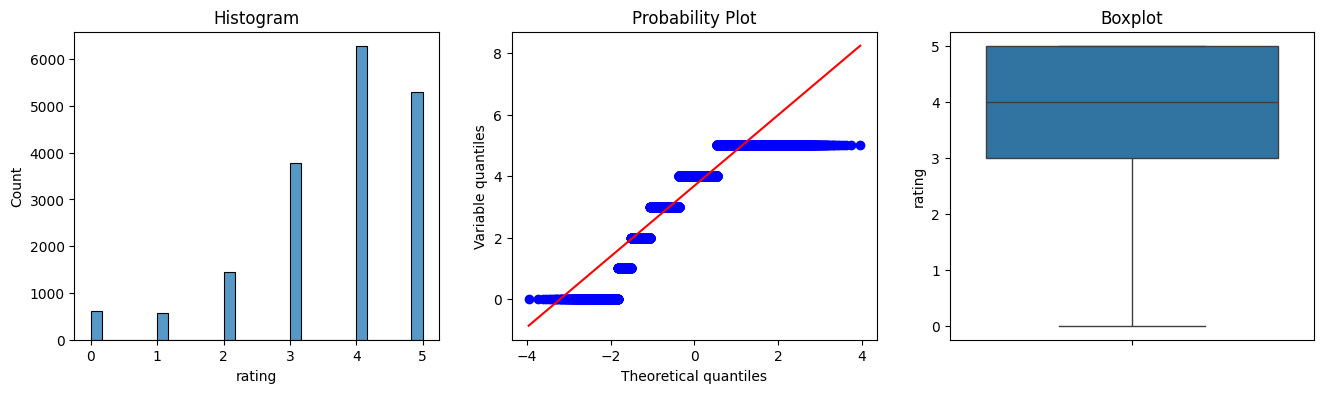

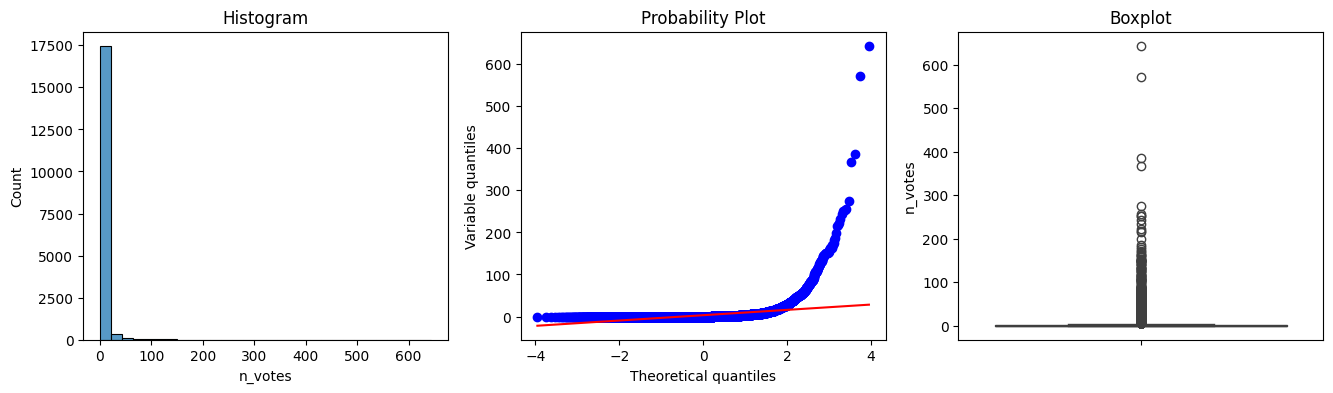

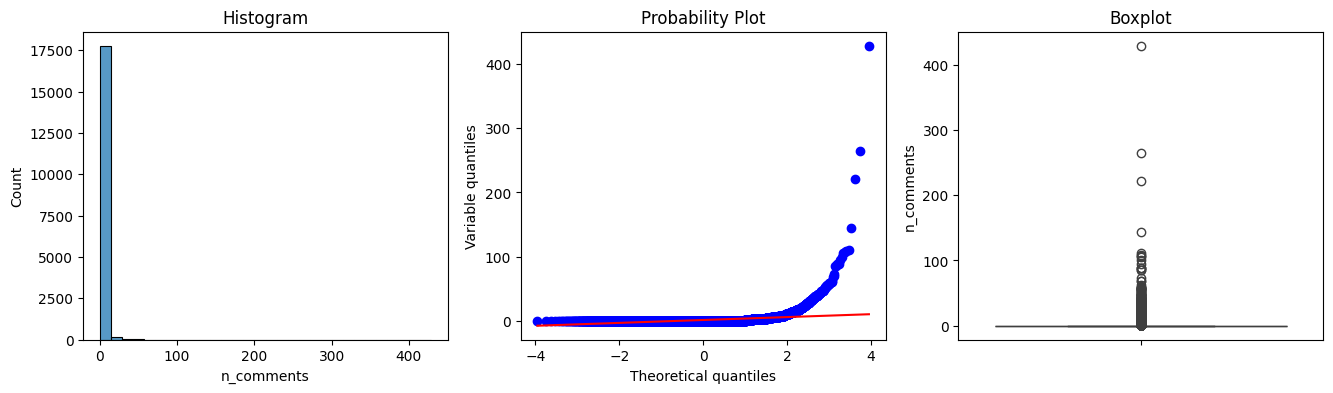

In [26]:
col_outlier = ['rating','n_votes','n_comments']

for col in col_outlier:
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(data[col], bins=30)
    plt.title('Histogram')

    # plot Q-Q
    plt.subplot(1, 3, 2)
    stats.probplot(data[col], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # box plot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=data[col])
    plt.title('Boxplot')

    plt.show()

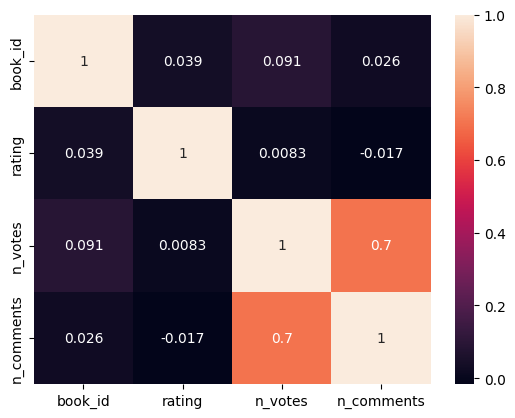

In [27]:
# Select only numeric columns for correlation calculation
numeric_train = data.select_dtypes(include=[np.number])

# Calculate the correlation matrix on just the numeric data
corrMatrix = numeric_train.corr()

# Create a heatmap
sns.heatmap(corrMatrix, annot=True)
plt.show()

#### Visualization

In [28]:
# setting id as index column
data.set_index("user_id", inplace = True)
data.set_index("book_id", inplace = True)

##### Rating and Number of Votes Distribution

In [29]:
# Calculate the average number of votes and comments per rating
avg_data = data.groupby('rating')[['n_votes', 'n_comments']].mean().reset_index()

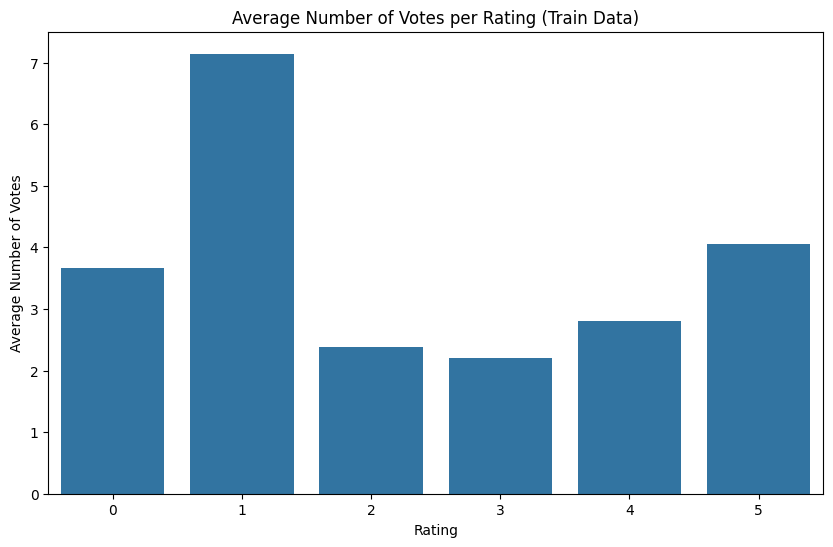

In [30]:
# Bar plot for train data
plt.figure(figsize=(10, 6))
sns.barplot(x='rating', y='n_votes', data=avg_data)
plt.title('Average Number of Votes per Rating (Train Data)')
plt.xlabel('Rating')
plt.ylabel('Average Number of Votes')
plt.show()

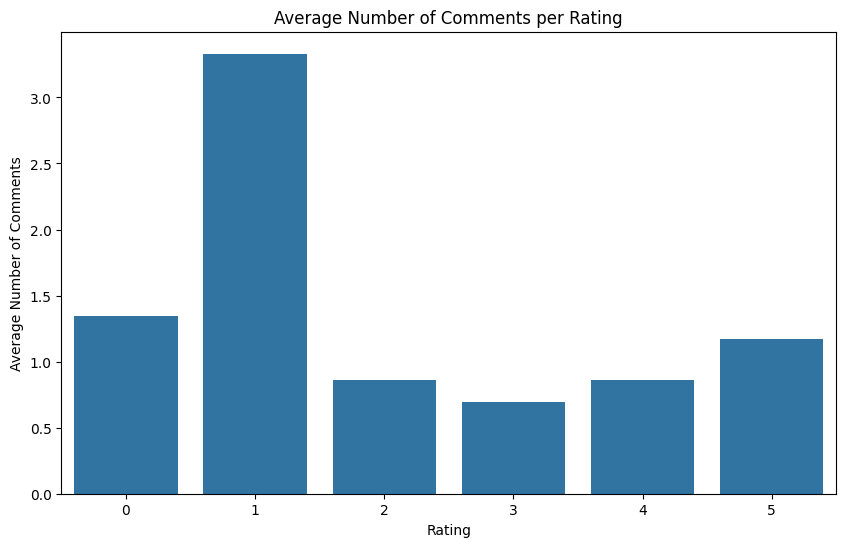

In [31]:
# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='rating', y='n_comments', data=avg_data)
plt.title('Average Number of Comments per Rating')
plt.xlabel('Rating')
plt.ylabel('Average Number of Comments')
plt.show()

##### Number of Votes and Number of Comments Distributions

In [32]:
# Check if there are any duplicate indices
print(data.index.duplicated().sum())

# If there are duplicates, reset the index
if data.index.duplicated().any():
    data.reset_index(drop=True, inplace=True)

8555


In [33]:
print("Max n_votes:", data['n_votes'].max())
print("Max n_comments:", data['n_comments'].max())

Max n_votes: 644
Max n_comments: 429


In [34]:
votes_bins = [0, 50, 100, 500, 1000, data['n_votes'].max() + 1]
comments_bins = [0, 10, 50, 100, 500, data['n_comments'].max() + 1]

print("Votes bins:", votes_bins)
print("Comments bins:", comments_bins)

Votes bins: [0, 50, 100, 500, 1000, 645]
Comments bins: [0, 10, 50, 100, 500, 430]


In [35]:
# Check differences between bins to ensure they are all positive
print("Votes bins differences:", np.diff(votes_bins))
print("Comments bins differences:", np.diff(comments_bins))

Votes bins differences: [  50   50  400  500 -355]
Comments bins differences: [ 10  40  50 400 -70]


In [36]:
# Manually set the last bin to be larger than any possible value in the dataset for both votes and comments
votes_bins = [0, 50, 100, 500, 1000]
comments_bins = [0, 10, 50, 100, 500]

# Extend the last bin beyond the highest predefined value if necessary
votes_bins.append(votes_bins[-1] + 500)
comments_bins.append(comments_bins[-1] + 500)

In [37]:
# Apply binning again with corrected bins
data['votes_bin'] = pd.cut(data['n_votes'], bins=votes_bins, right=False)
data['comments_bin'] = pd.cut(data['n_comments'], bins=comments_bins, right=False)

In [38]:
# Check new differences between bins to ensure all are positive
print("New Votes bins differences:", np.diff(votes_bins))
print("New Comments bins differences:", np.diff(comments_bins))

New Votes bins differences: [ 50  50 400 500 500]
New Comments bins differences: [ 10  40  50 400 500]


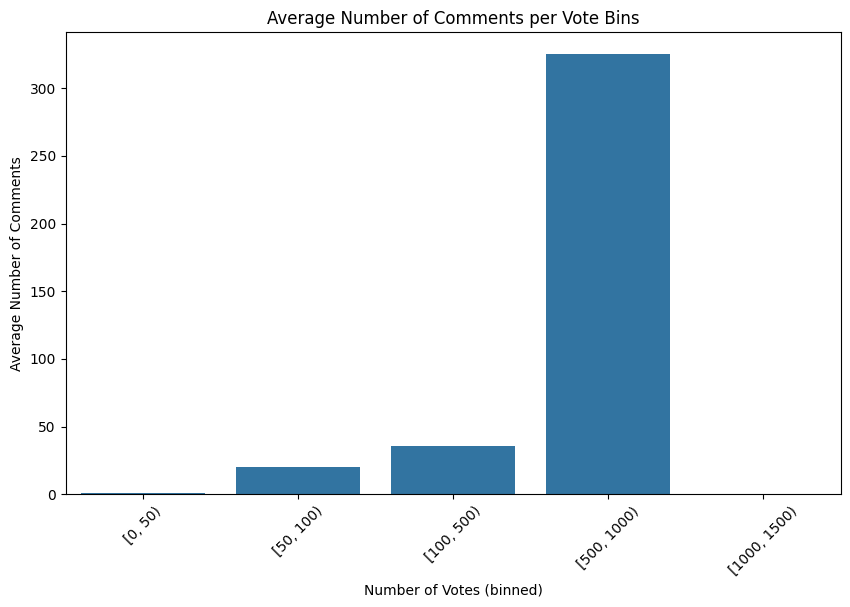

In [39]:
avg_comments_per_vote_bin = data.groupby('votes_bin')['n_comments'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='votes_bin', y='n_comments', data=avg_comments_per_vote_bin)
plt.title('Average Number of Comments per Vote Bins')
plt.xlabel('Number of Votes (binned)')
plt.ylabel('Average Number of Comments')
plt.xticks(rotation=45)
plt.show()

#### WordCloud

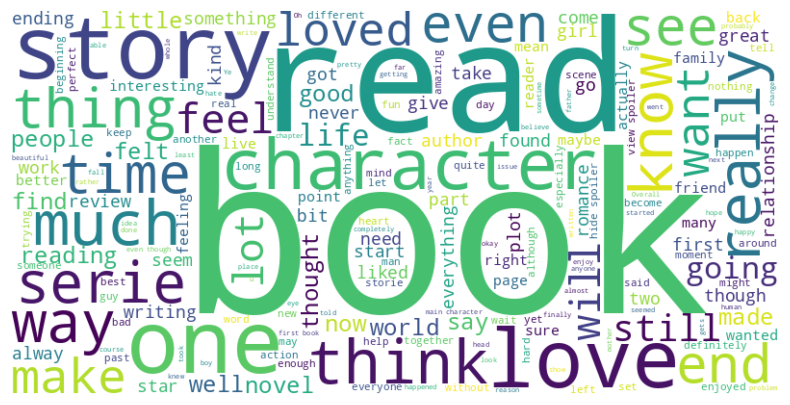

In [40]:
text = ' '.join(review for review in data['review_text'])

# Generate a word cloud image
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(text)

# Display the word cloud image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Top N Words

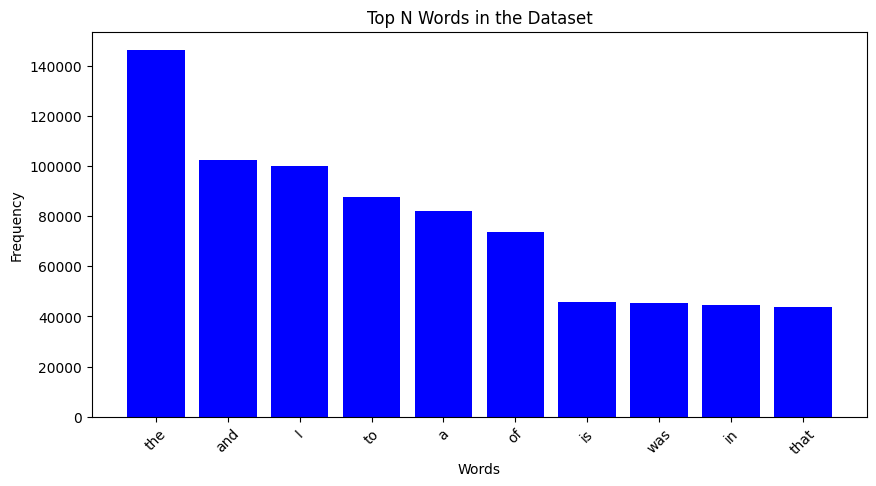

In [41]:
# Tokenize the text
words = text.split()

# Get frequencies of each word
word_counts = Counter(words)

# Determine the number of top words to display, e.g., top 10
top_n = 10
top_words = word_counts.most_common(top_n)
top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

# Plot
plt.figure(figsize=(10, 5))
plt.bar(top_words_df['Word'], top_words_df['Frequency'], color ='blue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top N Words in the Dataset')
plt.xticks(rotation=45)
plt.show()

## Sentiment Analysis

### **Label anotator sentiment**

To insert labels such as 'positive', 'neutral', or 'negative' for the DataFrame, we would typically go through a sentiment analysis process. This can be done either:


**1. Manually by reading through each text and assigning a label based on the sentiment conveyed**

For manual labeling, we could create a new column in the DataFrame and insert the labels directly.


**2. Automatically using a sentiment analysis tool or model**

For automatic labeling, we'd typically use a pre-trained sentiment analysis model from a library like NLTK, TextBlob, or through a service like Google Cloud Natural Language API.

In [42]:
def assign_sentiment_from_rating(rating):
    # Assign sentiment based on rating
    if rating in [4, 5]:
        return 'positive'
    elif rating in [0, 1, 2]:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'undefined'

In [43]:
data['sentiment'] = data['rating'].apply(assign_sentiment_from_rating)

In [44]:
label_mapping = {'positive': 0, 'negative': 1, 'neutral': 2}

# Replace string labels with integers
data['sentiment'] = data['sentiment'].replace(label_mapping)

In [45]:
# Validate the number of records and proportions
print("Total records sampled:", data.shape[0])
print(data['sentiment'].value_counts(normalize=True))  # Check the percentage distribution

Total records sampled: 17997
sentiment
0    0.643052
2    0.209979
1    0.146969
Name: proportion, dtype: float64


In [46]:
print(data[['rating', 'sentiment']].head())

   rating  sentiment
0       4          0
1       4          0
2       4          0
3       4          0
4       4          0


## Train / Validation split

In [47]:
sentiments = data['sentiment'].values.tolist()
reviews = data['review_text'].values.tolist()

training_sentences, validation_sentences, training_labels, validation_labels = train_test_split(
    reviews,
    sentiments,
    test_size=0.2,
    stratify=sentiments
)

## Tokenization

In [48]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [49]:
tokenizer([training_sentences[0]], truncation=True,
                            padding=True, max_length=128)

{'input_ids': [[101, 10166, 999, 2054, 2019, 4566, 999, 999, 999, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [50]:
train_encodings = tokenizer(training_sentences,
                            truncation=True,
                            padding=True,
                            max_length=512,
                            return_tensors="tf")

val_encodings = tokenizer(validation_sentences,
                          truncation=True,
                          padding=True,
                          max_length=512,
                          return_tensors="tf")

## TensorFlow Dataset

In [51]:
print("Number of training inputs:", train_encodings['input_ids'].shape[0])
print("Number of training labels:", len(training_labels))

print("Number of validation inputs:", val_encodings['input_ids'].shape[0])
print("Number of validation labels:", len(validation_labels))

Number of training inputs: 14397
Number of training labels: 14397
Number of validation inputs: 3600
Number of validation labels: 3600


In [52]:
train_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask']
}, training_labels)).shuffle(100).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask']
}, validation_labels)).shuffle(100).batch(16)

## Model

### Training

In [53]:
# Verify the shapes of input_ids and attention_mask
for inputs, labels in train_dataset.take(1):
    print("Input IDs shape:", inputs['input_ids'].shape)
    print("Attention mask shape:", inputs['attention_mask'].shape)

Input IDs shape: (16, 512)
Attention mask shape: (16, 512)


In [54]:
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer

# Load model
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

# Compile model
# using categorical labels
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [55]:
# Take one batch from the training dataset
for batch in train_dataset.take(1):
    inputs, labels = batch
    # Try to perform a forward pass
    try:
        outputs = model(inputs)
        print("Forward pass successful. Outputs:", outputs)
    except Exception as e:
        print("Error during model forward pass:", e)

Forward pass successful. Outputs: TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(16, 3), dtype=float32, numpy=
array([[-0.13709599, -0.03457291,  0.07345338],
       [-0.11971421, -0.06373505,  0.03835793],
       [-0.08992567, -0.06706138,  0.03187665],
       [-0.12928161, -0.04305618,  0.00178179],
       [-0.09297135, -0.09684218,  0.0503749 ],
       [-0.15282866, -0.05857237,  0.03142175],
       [-0.1499812 , -0.0719778 ,  0.06170709],
       [-0.08052247, -0.07381297,  0.00861559],
       [-0.13373835, -0.06417422,  0.04441424],
       [-0.12625122, -0.0406234 ,  0.01596241],
       [-0.11439008, -0.08727643,  0.05203541],
       [-0.08695026, -0.0659273 ,  0.06460887],
       [-0.08570255, -0.0851627 ,  0.06169615],
       [-0.13256364, -0.08313809,  0.04966047],
       [-0.10727127, -0.07686702,  0.0425434 ],
       [-0.15368898, -0.06455821,  0.01994215]], dtype=float32)>, hidden_states=None, attentions=None)


In [56]:
# Check a sample from the dataset to ensure labels are included and correctly formatted
for inputs, labels in train_dataset.take(1):
    print("Input format:", type(inputs), inputs.keys())
    print("Label format:", type(labels), labels.shape, labels.dtype)

Input format: <class 'dict'> dict_keys(['input_ids', 'attention_mask'])
Label format: <class 'tensorflow.python.framework.ops.EagerTensor'> (16,) <dtype: 'int32'>


In [ ]:
try:
    history = model.fit(
        train_dataset,  # Dataset already shuffled and batched
        epochs=5,
        validation_data=val_dataset
    )
    print("Training completed successfully.")
except Exception as e:
    print("Error during training:", e)

Epoch 1/5
260/900 [=======>......................] - ETA: 1:22:43 - loss: 0.7851 - accuracy: 0.6611

### Plot

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
# Create a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(10, 5))

# Create the first y-axis for accuracy
color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(train_accuracy, label='Train Accuracy', color=color)
ax1.plot(val_accuracy, label='Validation Accuracy', color=color, linestyle='dashed')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

# Create a second y-axis for loss, shared with the same x-axis
ax2 = ax1.twinx()  # instantiate a second axes
color = 'tab:red'
ax2.set_ylabel('Loss', color=color)
ax2.plot(train_loss, label='Train Loss', color=color)
ax2.plot(val_loss, label='Validation Loss', color=color, linestyle='dashed')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

# Title of the plot
plt.title('Training & Validation Accuracy and Loss')

# Show plot
plt.show()

### Save Model

In [ ]:
model.save_pretrained("/content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1/sentiment")

### Load Model

In [ ]:
loaded_model = TFDistilBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1/sentiment")

### Prediction

In [ ]:
test_sentence = "started interesting thriller woman run mysterious pass story took strange twists turns ends talky talky reveal."


predict_input = tokenizer.encode(test_sentence,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

tf_output = loaded_model.predict(predict_input)[0]


tf_prediction = tf.nn.softmax(tf_output, axis=1)
labels = ['Negative','Positive', 'Neutral']
label = tf.argmax(tf_prediction, axis=1)
label = label.numpy()
print(labels[label[0]])


## Hyperparameter Tuning


In [ ]:
pip install keras-tuner

In [ ]:
pip show tensorflow

In [ ]:
pip install --upgrade tensorflow

In [ ]:
from tensorflow.keras.optimizers import Adam

try:
    optimizer = Adam(learning_rate=0.001)
    print("Adam optimizer instantiated successfully.")
except Exception as e:
    print("Error instantiating Adam:", e)

In [ ]:
def build_model(hp):
    global loaded_model
    model = loaded_model

    # Retrieve hyperparameters
    model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
    lr = hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')

   model.compile(
        optimizer=Adam(lr),
        loss=model.compute_loss,
        metrics=['accuracy']
    )
    return model

In [ ]:
# Define the search tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='/content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1/sentiment',
    project_name='distilbert_tuning'
)

# Fit the tuner
tuner.search(train_dataset,
             epochs=2,
             validation_data=val_dataset,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

In [ ]:
# Fetch the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Get best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num=1)[0]
print("Best hyperparameters:", best_hyperparameters.values)